In [ ]:
!pip install transformers
!pip install datasets
!pip install -U PyYAML

     |████████████████████████████████| 2.8 MB 5.4 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 3.3 MB 38.2 MB/s 
     |████████████████████████████████| 636 kB 45.3 MB/s 
     |████████████████████████████████| 895 kB 48.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 270 kB 5.2 MB/s 
     |████████████████████████████████| 243 kB 38.7 MB/s 
     |████████████████████████████████| 1.3 MB 34.4 MB/s 
     |████████████████████████████████| 119 kB 51.1 MB/s 
     |████████████████████████████████| 294 kB 47.8 MB/s 
     |████████████████████████████████| 142 kB 50.3 MB/s 


1. Separate your text into two strings:

    i. all the books concatenated that belong to the "successful" class

    ii. all the book concatenated that belong to the "unsuccessful" class

2. Get the vocabulary for these two strings: $V$

3. Count the number of words 
    - in the whole text: $n$
    - in the successful class: $n_s$
    - in the unsuccessful class: $n_u$

4. For each word in your vocabulary
    - Count the number of occurrences in the successful class: $C(word, successful)$
    - Count the number of occurrences in the unsuccessful class: $C(word, unsuccessful)$

5. For each word in your vocabulary
    - Calculate its probability of being in the successful class: $p(word, successful) = \frac{C(word, successful) + \alpha}{n_s + \alpha * |V|}$
    - Calculate its probability of being in the unsuccessful class: $p(word, unsuccessful) = \frac{C(word, unsuccessful) + \alpha}{n_u + \alpha * |V|}$
    - Calculate its probability of being in the corpus: $p(word, \cdot) = \frac{C(word, successful)+C(word, unsuccessful)+2 \alpha}{n + 2 \alpha * |V|}$

6. Calculate the PMI for each word, class pair

$$PMI(word, class) = log(\frac{p(word,class)}{p(word,\cdot)p(\cdot,class)})$$
where $p(\cdot, class) = \frac{n_{class}}{n}$

In [ ]:
from pathlib import Path
import pandas as pd
import yaml
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import auth
auth.authenticate_user()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Shared Functions

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_single_vs_allOther_text(data_yaml, book_id):
  counter = 0
  text_single = ""
  text_allOther = []
  with open(data_yaml) as file:
    documents = yaml.full_load(file)
    for _, doc in documents.items():
      for d in doc:
        path = list(dataset_base.rglob(d))[0]
        with open(path, 'r', encoding = 'utf-8') as file:
          book = file.read()
          book = book.replace('\n', ' ')
          if d == book_id:
            text_single = book
          else:
            text_allOther.append(book)

          counter = counter + 1
          if counter % 100 == 0:
            print(counter)
      
  return text_single, ' '.join(text_allOther)



def get_successful_and_unsuccessful_text(data_yaml):
  counter = 0
  text_successful = ""
  text_unsuccessful = ""
  with open(data_yaml) as file:
      documents = yaml.full_load(file)
      for train_test, doc in documents.items():
          for d in doc:
              path = list(dataset_base.rglob(d))[0]
              classBool = os.path.dirname(path).rsplit('/', 1)[1] == "success"
              with open(path, 'r', encoding = 'utf-8') as file:
                book = file.read()
                book = book.replace('\n', ' ')
                if classBool == True:
                  text_successful = text_successful + " " + book
                else:
                  text_unsuccessful = text_unsuccessful + " " + book

                counter = counter + 1
                if counter % 100 == 0:
                  print(counter)

  return text_successful, text_unsuccessful


def get_successful_and_unsuccessful_text_csv(data_yaml):
  counter = 0
  text_successful = ""
  text_unsuccessful = ""
  with open(data_yaml) as file:
      documents = yaml.full_load(file)
      for train_test, doc in documents.items():
          for d in doc:
              
              path = list(dataset_base.rglob(d))[0]
              
              classBool = os.path.dirname(path).rsplit('/', 1)[1] == "success"
              book_df = pd.read_csv(path, names = ['sentence'], skip_blank_lines=True)

              if book_df['sentence'].iloc[0] == '0':
                book_df = book_df.drop(0)

              for _, sent in book_df.iterrows():
                book_sent = str(sent['sentence'])
                if classBool == True:
                  text_successful = text_successful + " " + book_sent
                else:
                  text_unsuccessful = text_unsuccessful + " " + book_sent

              counter = counter + 1
              if counter % 100 == 0:
                print(counter)

  return text_successful, text_unsuccessful

def get_PMIs(text_class_1, text_class_2, goodreads_vectorizer):

  len_vocab = len(goodreads_vectorizer.vocabulary_)
  vector_class_1 = np.array(goodreads_vectorizer.transform([text_class_1]).toarray()[0])
  vector_class_2 = np.array(goodreads_vectorizer.transform([text_class_2]).toarray()[0])
  id_to_word = {v: k for k, v in goodreads_vectorizer.vocabulary_.items()}

  n_s = np.sum(vector_class_1)
  n_u = np.sum(vector_class_2)
  n = n_s + n_u

  alpha = 100
  word_probs_class_1 = (vector_class_1 + alpha)/(n_s + alpha*len_vocab)
  word_probs_class_2 = (vector_class_2 + alpha)/(n_s + alpha*len_vocab)
  word_probs_corpus = (vector_class_1 + vector_class_2 + 2*alpha)/(n + 2*alpha*len_vocab)

  PMI_class_1 = np.log(word_probs_class_1 / (word_probs_corpus * (n_s / n)))
  PMI_class_2 = np.log(word_probs_class_2 / (word_probs_corpus * (n_u / n)))

  return PMI_class_1, PMI_class_2

# Pointwise Mutual Info Analysis on Raw Text

In [ ]:
dataset_base = Path(r"/content/drive/MyDrive/Thesis/BookSuccessPredictor/datasets/goodreads_maharjan_super/raw_preprocessed/goodreads_maharjan_trimmed")
data_yaml = dataset_base / "train_test_val_80_20_split_goodreads.yaml"

# text_class_1, text_class_2 = get_single_vs_allOther_text(data_yaml, '13724_the+frontiersmen.txt')
text_successful, text_unsuccessful = get_successful_and_unsuccessful_text(data_yaml)

100
200
300
400
500
600
700
800
900


## Calculate PMIs

In [33]:
goodreads_vectorizer = CountVectorizer()
goodreads_vectorizer.fit([text_successful + text_unsuccessful])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [34]:
PMI_successful, PMI_unsuccessful = get_PMIs(text_successful, text_unsuccessful, goodreads_vectorizer)

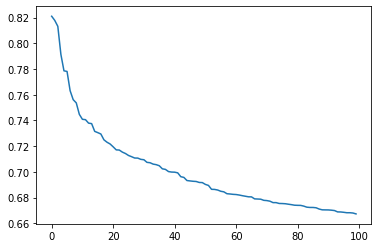

In [ ]:
import matplotlib.pyplot as plt
plt.plot(sorted(PMI_successful, reverse=True)[0:100])

In [21]:
sorted(PMI_successful, reverse=True)[0:10]

[0.8210627929493921,
 0.8178348026495347,
 0.8132098144882633,
 0.7913813787110774,
 0.7785944901001618,
 0.7781131322759086,
 0.763127583095457,
 0.7561512557938824,
 0.7536417202459268,
 0.7447034366958954]

In [15]:
PMI_successful

array([0.25160307, 0.29104425, 0.23515176, ..., 0.23515176, 0.23515176,
       0.23515176])

In [22]:
sorted(PMI_unsuccessful, reverse=True)[0:10]

[1.677264800758259,
 1.5529446577791144,
 1.5232437049664287,
 1.515775410358903,
 1.4944774126799687,
 1.4894806286769688,
 1.4830232729008053,
 1.4712135074933999,
 1.4694236857292533,
 1.4648526253309524]

## Analysis

In [35]:
id_to_word = {v: k for k, v in goodreads_vectorizer.vocabulary_.items()}

In [43]:
indices_s = (PMI_successful).argsort()[:10]
[id_to_word[x] for x in indices_s]

['00',
 '000',
 '000012',
 '000014',
 '000015',
 '000016',
 '000017',
 '0001',
 '0009',
 '00176']

In [45]:
indices_u = (PMI_unsuccessful).argsort()[:10]
[id_to_word[x] for x in indices_u]

['00',
 '000',
 '000012',
 '000014',
 '000015',
 '000016',
 '000017',
 '0001',
 '0009',
 '00176']

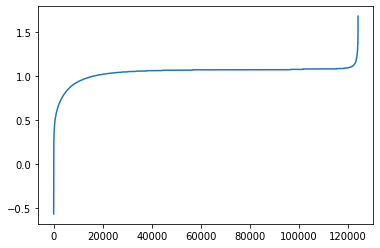

In [39]:
PMI_unsuccessful.sort()
plt.plot(PMI_unsuccessful)

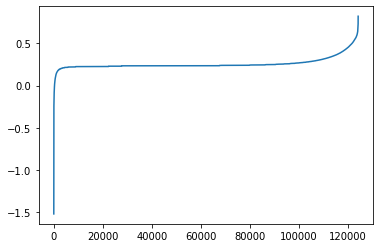

In [40]:
PMI_successful.sort()
plt.plot(PMI_successful)

# Pointwise Mutual Analysis on Text after NER Preprocessing

## Getting the text

### Generating the concatenated text

In [ ]:
dataset_base = Path(r"/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/goodreads_maharjan_trimmed_and_nered")
data_yaml = dataset_base / "train_test_val_split_goodreads.yaml"

text_successful_ner, text_unsuccessful_ner = get_successful_and_unsuccessful_text_csv(data_yaml)

### Getting the already concatenated text

In [ ]:
with open('/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/goodreads_maharjan_trimmed_and_nered/all_successful_text.txt', 'r') as file:
    successful_text_ner = file.read()

with open('/content/drive/MyDrive/Thesis/Datasets/book_preprocessing/goodreads_maharjan_trimmed_and_nered/all_unsuccessful_text.txt', 'r') as file:
    unsuccessful_text_ner = file.read()

### Calculate PMIs

In [ ]:
goodreads_vectorizer_ner = CountVectorizer()
goodreads_vectorizer_ner.fit([successful_text_ner + unsuccessful_text_ner])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
PMI_successful_ner, PMI_unsuccessful_ner = get_PMIs(successful_text_ner, unsuccessful_text_ner, goodreads_vectorizer_ner)

### Analysis

In [ ]:
id_to_word_ner = {v: k for k, v in goodreads_vectorizer_ner.vocabulary_.items()}

In [ ]:
indices_s_ner = (-PMI_successful_ner).argsort()[:10]
[id_to_word[x] for x in indices_s_ner]

['freezer',
 'demonologists',
 'tamped',
 'swollen',
 'loamed',
 'welch',
 'patara',
 'siue',
 'bagnacavallo',
 'japanese']

In [ ]:
indices_u_ner = (-PMI_unsuccessful_ner).argsort()[:10]
[id_to_word[x] for x in indices_u_ner]

['disproportional',
 'hauty',
 'wastebasket',
 'endyte',
 'reverse',
 'christen',
 'sport',
 'unsound',
 'memnonian',
 'lenchester']

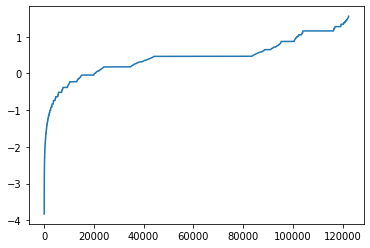

In [ ]:
PMI_unsuccessful_ner.sort()
plt.plot(PMI_unsuccessful_ner)

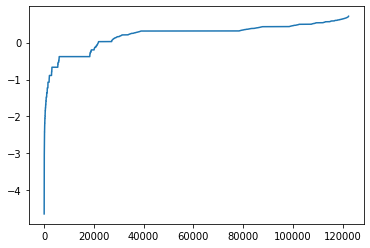

In [ ]:
PMI_successful_ner.sort()
plt.plot(PMI_successful_ner)